# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [71]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   perception              1206 non-null   int64  
 1   cha                     1206 non-null   int64  
 2   wis                     1206 non-null   int64  
 3   hp                      1206 non-null   int64  
 4   int                     1206 non-null   int64  
 5   will                    1206 non-null   int64  
 6   focus                   1206 non-null   int32  
 7   fortitude               1206 non-null   int64  
 8   con                     1206 non-null   int64  
 9   dex                     1206 non-null   int64  
 10  str                     1206 non-null   int64  
 11  reflex                  1206 non-null   int64  
 12  land_speed              1206 non-null   float64
 13  ac                      1206 non-null   int64  
 14  book                    1206 non-null   

In [73]:
df.head()

,perception,cha,wis,hp,int,will,focus,fortitude,con,dex,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,20,1,2,215,1,17,1,22,5,2,...,0,0,0,0,0,0,23,22.0,0,0.0
1,16,1,2,220,-4,16,0,21,5,0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,17,-2,3,175,-4,15,0,20,6,3,...,0,0,0,0,0,0,21,16.0,0,0.0
3,30,6,5,315,6,32,1,30,5,4,...,1,0,1,0,0,0,33,31.5,0,0.0
4,6,1,1,20,-1,4,1,6,1,3,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [74]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [75]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [76]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


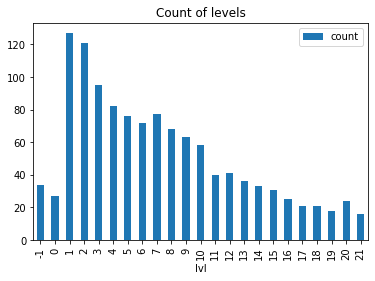

In [77]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [78]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [79]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [80]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [81]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [82]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not m

In [83]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.91
RMSE: 0.96
MAE: 0.46


In [85]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [86]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.11
RMSE test: 0.96


###### MAE by level

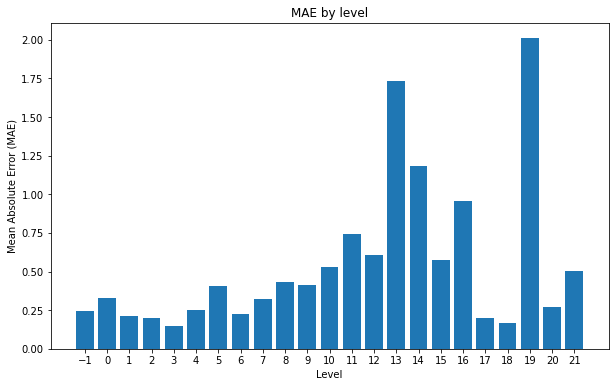

In [87]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [88]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.91
RMSE: 0.96

Round type: round
MSE: 0.94
RMSE: 0.97

Round type: 0.33
MSE: 0.91
RMSE: 0.96

Round type: 0.45
MSE: 0.90
RMSE: 0.95



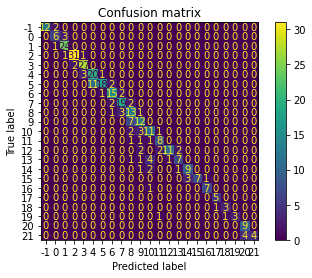

In [89]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [90]:
from training.results import assess_regression_model

In [91]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 23:06:10,864] A new study created in memory with name: no-name-4c2010a1-4241-4924-a010-e7a8191dafbb

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.141713 + 0.0319683
[200]	cv_agg's l2: 0.136895 + 0.0300848
[300]	cv_agg's l2: 0.135858 + 0.0295891



feature_fraction, val_score: 0.135666:  14%|######4                                      | 1/7 [00:02<00:15,  2.50s/it][I 2023-10-28 23:06:13,377] Trial 0 finished with value: 0.13566601715274723 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.13566601715274723.

feature_fraction, val_score: 0.135666:  14%|######4                                      | 1/7 [00:02<00:15,  2.50s/it]

[400]	cv_agg's l2: 0.135731 + 0.0296277
Early stopping, best iteration is:
[320]	cv_agg's l2: 0.135666 + 0.0295308
[100]	cv_agg's l2: 0.145521 + 0.0361756
[200]	cv_agg's l2: 0.142165 + 0.0358856
[300]	cv_agg's l2: 0.141873 + 0.0358399



feature_fraction, val_score: 0.135666:  29%|############8                                | 2/7 [00:05<00:13,  2.63s/it][I 2023-10-28 23:06:16,099] Trial 1 finished with value: 0.1418691277745783 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.13566601715274723.

feature_fraction, val_score: 0.135666:  29%|############8                                | 2/7 [00:05<00:13,  2.63s/it]

[400]	cv_agg's l2: 0.141696 + 0.035661
Early stopping, best iteration is:
[320]	cv_agg's l2: 0.135666 + 0.0295308
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922


[700]	cv_agg's l2: 0.132743 + 0.0289504
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.132599 + 0.0289625


feature_fraction, val_score: 0.132599:  43%|###################2                         | 3/7 [00:10<00:15,  3.87s/it][I 2023-10-28 23:06:21,443] Trial 2 finished with value: 0.1325987519658841 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.1325987519658841.

feature_fraction, val_score: 0.132599:  43%|###################2                         | 3/7 [00:10<00:15,  3.87s/it]

[100]	cv_agg's l2: 0.149988 + 0.0398486
[200]	cv_agg's l2: 0.14649 + 0.0378979
[300]	cv_agg's l2: 0.146666 + 0.0382287
[400]	cv_agg's l2: 0.146604 + 0.0379543
[500]	cv_agg's l2: 0.146268 + 0.0376928
[600]	cv_agg's l2: 0.146281 + 0.0376655



feature_fraction, val_score: 0.132599:  43%|###################2                         | 3/7 [00:15<00:15,  3.87s/it]

[700]	cv_agg's l2: 0.146152 + 0.0373985
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.132599 + 0.0289625



feature_fraction, val_score: 0.132599:  57%|#########################7                   | 4/7 [00:15<00:12,  4.33s/it][I 2023-10-28 23:06:26,473] Trial 3 finished with value: 0.14620699648424085 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.1325987519658841.

feature_fraction, val_score: 0.132599:  57%|#########################7                   | 4/7 [00:15<00:12,  4.33s/it]

[100]	cv_agg's l2: 0.142214 + 0.0369928
[200]	cv_agg's l2: 0.137185 + 0.0362941
[300]	cv_agg's l2: 0.13618 + 0.0369484
[400]	cv_agg's l2: 0.135487 + 0.0365732
[500]	cv_agg's l2: 0.135161 + 0.0367135
[600]	cv_agg's l2: 0.134947 + 0.0367827



feature_fraction, val_score: 0.132599:  71%|################################1            | 5/7 [00:20<00:09,  4.69s/it]

[700]	cv_agg's l2: 0.134938 + 0.0367872
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.132599 + 0.0289625


[I 2023-10-28 23:06:31,812] Trial 4 finished with value: 0.13495115284890058 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.1325987519658841.

feature_fraction, val_score: 0.132599:  71%|################################1            | 5/7 [00:20<00:09,  4.69s/it]

[100]	cv_agg's l2: 0.154187 + 0.0353511
[200]	cv_agg's l2: 0.151938 + 0.0355101
[300]	cv_agg's l2: 0.151854 + 0.0351687
[400]	cv_agg's l2: 0.152024 + 0.0351835
[500]	cv_agg's l2: 0.152152 + 0.0354364
[600]	cv_agg's l2: 0.152185 + 0.0354274


[700]	cv_agg's l2: 0.152309 + 0.0353186
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.132599 + 0.0289625


feature_fraction, val_score: 0.132599:  86%|######################################5      | 6/7 [00:26<00:04,  4.95s/it][I 2023-10-28 23:06:37,266] Trial 5 finished with value: 0.1522459794808903 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.1325987519658841.

feature_fraction, val_score: 0.132599:  86%|######################################5      | 6/7 [00:26<00:04,  4.95s/it]

[100]	cv_agg's l2: 0.138158 + 0.0283635
[200]	cv_agg's l2: 0.135488 + 0.0286766
[300]	cv_agg's l2: 0.134946 + 0.0284854
[400]	cv_agg's l2: 0.134875 + 0.0285305
[500]	cv_agg's l2: 0.134771 + 0.0284873
[600]	cv_agg's l2: 0.134891 + 0.0285103



feature_fraction, val_score: 0.132599: 100%|#############################################| 7/7 [00:32<00:00,  4.61s/it]


[700]	cv_agg's l2: 0.135036 + 0.0285466
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.132599 + 0.0289625



num_leaves, val_score: 0.132599:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



num_leaves, val_score: 0.129781:   5%|##5                                               | 1/20 [00:03<01:10,  3.71s/it][I 2023-10-28 23:06:46,828] Trial 7 finished with value: 0.12978101998739006 and parameters: {'num_leaves': 17}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:   5%|##5                                               | 1/20 [00:03<01:10,  3.71s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  10%|#####                                             | 2/20 [00:09<01:31,  5.07s/it][I 2023-10-28 23:06:52,859] Trial 8 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  10%|#####                                             | 2/20 [00:09<01:31,  5.07s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  15%|#######5                                          | 3/20 [00:15<01:30,  5.34s/it][I 2023-10-28 23:06:58,513] Trial 9 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 242}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  15%|#######5                                          | 3/20 [00:15<01:30,  5.34s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.231982 + 0.0395646
[200]	cv_agg's l2: 0.20596 + 0.0379391
[300]	cv_agg's l2: 0.19232 + 0.0364829
[400]	cv_agg's l2: 0.184057 + 0.0356123
[500]	cv_agg's l2: 0.1781 + 0.0354843
[600]	cv_agg's l2: 0.174291 + 0.0355343



num_leaves, val_score: 0.129781:  20%|##########                                        | 4/20 [00:16<01:00,  3.76s/it][I 2023-10-28 23:06:59,862] Trial 10 finished with value: 0.17476146639524917 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  20%|##########                                        | 4/20 [00:16<01:00,  3.76s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.197996 + 0.0320058
[200]	cv_agg's l2: 0.182647 + 0.0319183
[300]	cv_agg's l2: 0.173882 + 0.0310031
[400]	cv_agg's l2: 0.170059 + 0.0296881
[500]	cv_agg's l2: 0.166613 + 0.028206
[600]	cv_agg's l2: 0.165361 + 0.0281052



num_leaves, val_score: 0.129781:  25%|############5                                     | 5/20 [00:19<00:49,  3.31s/it][I 2023-10-28 23:07:02,356] Trial 11 finished with value: 0.1656243561868223 and parameters: {'num_leaves': 4}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  25%|############5                                     | 5/20 [00:19<00:49,  3.31s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  30%|###############                                   | 6/20 [00:25<00:59,  4.22s/it][I 2023-10-28 23:07:08,352] Trial 12 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 105}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  30%|###############                                   | 6/20 [00:25<00:59,  4.22s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  35%|#################5                                | 7/20 [00:30<00:59,  4.54s/it][I 2023-10-28 23:07:13,552] Trial 13 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 106}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  35%|#################5                                | 7/20 [00:30<00:59,  4.54s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  40%|####################                              | 8/20 [00:36<00:58,  4.89s/it][I 2023-10-28 23:07:19,201] Trial 14 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  40%|####################                              | 8/20 [00:36<00:58,  4.89s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  45%|######################5                           | 9/20 [00:41<00:56,  5.16s/it][I 2023-10-28 23:07:24,958] Trial 15 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  45%|######################5                           | 9/20 [00:41<00:56,  5.16s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  50%|########################5                        | 10/20 [00:47<00:52,  5.29s/it][I 2023-10-28 23:07:30,546] Trial 16 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  50%|########################5                        | 10/20 [00:47<00:52,  5.29s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  55%|##########################9                      | 11/20 [00:53<00:48,  5.39s/it][I 2023-10-28 23:07:36,148] Trial 17 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 56}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  55%|##########################9                      | 11/20 [00:53<00:48,  5.39s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  60%|#############################4                   | 12/20 [00:58<00:43,  5.39s/it][I 2023-10-28 23:07:41,533] Trial 18 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 53}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  60%|#############################4                   | 12/20 [00:58<00:43,  5.39s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  65%|###############################8                 | 13/20 [01:03<00:38,  5.44s/it][I 2023-10-28 23:07:47,079] Trial 19 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 160}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  65%|###############################8                 | 13/20 [01:03<00:38,  5.44s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  70%|##################################3              | 14/20 [01:09<00:32,  5.43s/it][I 2023-10-28 23:07:52,479] Trial 20 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 37}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  70%|##################################3              | 14/20 [01:09<00:32,  5.43s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  75%|####################################7            | 15/20 [01:15<00:27,  5.58s/it][I 2023-10-28 23:07:58,410] Trial 21 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 256}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  75%|####################################7            | 15/20 [01:15<00:27,  5.58s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  80%|#######################################2         | 16/20 [01:21<00:22,  5.64s/it][I 2023-10-28 23:08:04,181] Trial 22 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 202}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  80%|#######################################2         | 16/20 [01:21<00:22,  5.64s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  85%|#########################################6       | 17/20 [01:26<00:16,  5.60s/it][I 2023-10-28 23:08:09,702] Trial 23 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 209}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  85%|#########################################6       | 17/20 [01:26<00:16,  5.60s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  90%|############################################1    | 18/20 [01:32<00:11,  5.74s/it][I 2023-10-28 23:08:15,753] Trial 24 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 118}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  90%|############################################1    | 18/20 [01:32<00:11,  5.74s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781:  95%|##############################################5  | 19/20 [01:38<00:05,  5.72s/it][I 2023-10-28 23:08:21,430] Trial 25 finished with value: 0.1327731888421469 and parameters: {'num_leaves': 83}. Best is trial 7 with value: 0.12978101998739006.

num_leaves, val_score: 0.129781:  95%|##############################################5  | 19/20 [01:38<00:05,  5.72s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138206 + 0.0300166
[200]	cv_agg's l2: 0.133781 + 0.0298556
[300]	cv_agg's l2: 0.133398 + 0.0295113
[400]	cv_agg's l2: 0.133108 + 0.0294576
[500]	cv_agg's l2: 0.132812 + 0.0290858
[600]	cv_agg's l2: 0.132756 + 0.0289922



num_leaves, val_score: 0.129781: 100%|#################################################| 20/20 [01:43<00:00,  5.19s/it]


Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569



bagging, val_score: 0.129781:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.187163 + 0.0564722
[200]	cv_agg's l2: 0.175198 + 0.0532582
[300]	cv_agg's l2: 0.175695 + 0.0519732
[400]	cv_agg's l2: 0.174321 + 0.0507038
[500]	cv_agg's l2: 0.172673 + 0.0471412
[600]	cv_agg's l2: 0.172064 + 0.0453872



bagging, val_score: 0.129781:  10%|#####3                                               | 1/10 [00:03<00:32,  3.56s/it][I 2023-10-28 23:08:30,576] Trial 27 finished with value: 0.1723269768240043 and parameters: {'bagging_fraction': 0.5255246007710613, 'bagging_freq': 7}. Best is trial 27 with value: 0.1723269768240043.

bagging, val_score: 0.129781:  10%|#####3                                               | 1/10 [00:03<00:32,  3.56s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.137062 + 0.0275933
[200]	cv_agg's l2: 0.132493 + 0.0248085
[300]	cv_agg's l2: 0.131677 + 0.0236034
[400]	cv_agg's l2: 0.131931 + 0.0232983
[500]	cv_agg's l2: 0.131834 + 0.0228322
[600]	cv_agg's l2: 0.131635 + 0.0226221



bagging, val_score: 0.129781:  20%|##########6                                          | 2/10 [00:07<00:31,  3.89s/it][I 2023-10-28 23:08:34,693] Trial 28 finished with value: 0.13157149758483164 and parameters: {'bagging_fraction': 0.9934217386697133, 'bagging_freq': 1}. Best is trial 28 with value: 0.13157149758483164.

bagging, val_score: 0.129781:  20%|##########6                                          | 2/10 [00:07<00:31,  3.89s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138338 + 0.0238121
[200]	cv_agg's l2: 0.132326 + 0.0220772
[300]	cv_agg's l2: 0.131109 + 0.0223887
[400]	cv_agg's l2: 0.130613 + 0.0221128
[500]	cv_agg's l2: 0.130608 + 0.0219346
[600]	cv_agg's l2: 0.130503 + 0.0218508



bagging, val_score: 0.129781:  30%|###############9                                     | 3/10 [00:11<00:28,  4.06s/it][I 2023-10-28 23:08:38,967] Trial 29 finished with value: 0.1304733428394571 and parameters: {'bagging_fraction': 0.9784728430488977, 'bagging_freq': 1}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  30%|###############9                                     | 3/10 [00:11<00:28,  4.06s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.14105 + 0.0286762
[200]	cv_agg's l2: 0.135654 + 0.0268085
[300]	cv_agg's l2: 0.134544 + 0.0262928
[400]	cv_agg's l2: 0.134012 + 0.025931
[500]	cv_agg's l2: 0.133832 + 0.0254781
[600]	cv_agg's l2: 0.133621 + 0.0250686



bagging, val_score: 0.129781:  40%|#####################2                               | 4/10 [00:15<00:24,  4.05s/it][I 2023-10-28 23:08:43,004] Trial 30 finished with value: 0.13368852427416608 and parameters: {'bagging_fraction': 0.9971433104821036, 'bagging_freq': 1}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  40%|#####################2                               | 4/10 [00:15<00:24,  4.05s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.14167 + 0.0299493
[200]	cv_agg's l2: 0.13617 + 0.0270897
[300]	cv_agg's l2: 0.135509 + 0.0268006
[400]	cv_agg's l2: 0.135472 + 0.0259334
[500]	cv_agg's l2: 0.135442 + 0.0255703
[600]	cv_agg's l2: 0.135167 + 0.0255716



bagging, val_score: 0.129781:  50%|##########################5                          | 5/10 [00:20<00:20,  4.14s/it][I 2023-10-28 23:08:47,300] Trial 31 finished with value: 0.13523336031120686 and parameters: {'bagging_fraction': 0.9885991800447611, 'bagging_freq': 1}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  50%|##########################5                          | 5/10 [00:20<00:20,  4.14s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.151868 + 0.0338608
[200]	cv_agg's l2: 0.147411 + 0.0305386
[300]	cv_agg's l2: 0.145282 + 0.029755
[400]	cv_agg's l2: 0.144403 + 0.0297136
[500]	cv_agg's l2: 0.144582 + 0.0300633
[600]	cv_agg's l2: 0.144212 + 0.0301819



bagging, val_score: 0.129781:  60%|###############################8                     | 6/10 [00:24<00:17,  4.32s/it][I 2023-10-28 23:08:51,967] Trial 32 finished with value: 0.14426114412283142 and parameters: {'bagging_fraction': 0.8622714708138788, 'bagging_freq': 3}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  60%|###############################8                     | 6/10 [00:24<00:17,  4.32s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.151929 + 0.0411989
[200]	cv_agg's l2: 0.147999 + 0.0386964
[300]	cv_agg's l2: 0.14591 + 0.0386513
[400]	cv_agg's l2: 0.145758 + 0.0384095
[500]	cv_agg's l2: 0.145854 + 0.0379783
[600]	cv_agg's l2: 0.145571 + 0.0375266



bagging, val_score: 0.129781:  70%|#####################################                | 7/10 [00:29<00:13,  4.39s/it][I 2023-10-28 23:08:56,497] Trial 33 finished with value: 0.14557871620706403 and parameters: {'bagging_fraction': 0.7979712047534733, 'bagging_freq': 3}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  70%|#####################################                | 7/10 [00:29<00:13,  4.39s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.14105 + 0.0286762
[200]	cv_agg's l2: 0.135654 + 0.0268085
[300]	cv_agg's l2: 0.134544 + 0.0262928
[400]	cv_agg's l2: 0.134012 + 0.025931
[500]	cv_agg's l2: 0.133832 + 0.0254781
[600]	cv_agg's l2: 0.133621 + 0.0250686



bagging, val_score: 0.129781:  80%|##########################################4          | 8/10 [00:33<00:08,  4.33s/it][I 2023-10-28 23:09:00,701] Trial 34 finished with value: 0.13368852427416608 and parameters: {'bagging_fraction': 0.9964907254975508, 'bagging_freq': 1}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  80%|##########################################4          | 8/10 [00:33<00:08,  4.33s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.152741 + 0.0286739
[200]	cv_agg's l2: 0.147244 + 0.027596
[300]	cv_agg's l2: 0.146616 + 0.0271183
[400]	cv_agg's l2: 0.14622 + 0.0278442
[500]	cv_agg's l2: 0.145989 + 0.0272374
[600]	cv_agg's l2: 0.145743 + 0.0275267



bagging, val_score: 0.129781:  90%|###############################################7     | 9/10 [00:38<00:04,  4.35s/it][I 2023-10-28 23:09:05,103] Trial 35 finished with value: 0.14562065189064322 and parameters: {'bagging_fraction': 0.8119045571505517, 'bagging_freq': 5}. Best is trial 29 with value: 0.1304733428394571.

bagging, val_score: 0.129781:  90%|###############################################7     | 9/10 [00:38<00:04,  4.35s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.166221 + 0.027144
[200]	cv_agg's l2: 0.163451 + 0.0247685
[300]	cv_agg's l2: 0.162343 + 0.0244318
[400]	cv_agg's l2: 0.162563 + 0.0249858
[500]	cv_agg's l2: 0.162599 + 0.0237045
[600]	cv_agg's l2: 0.162271 + 0.0233266



bagging, val_score: 0.129781: 100%|####################################################| 10/10 [00:42<00:00,  4.24s/it]


Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569



feature_fraction_stage2, val_score: 0.129781:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.13929 + 0.0263179
[200]	cv_agg's l2: 0.134736 + 0.0243694
[300]	cv_agg's l2: 0.13355 + 0.0237461
[400]	cv_agg's l2: 0.133026 + 0.0234075
[500]	cv_agg's l2: 0.133287 + 0.0233266
[600]	cv_agg's l2: 0.133273 + 0.0234441



feature_fraction_stage2, val_score: 0.129781:  17%|######3                               | 1/6 [00:04<00:21,  4.32s/it][I 2023-10-28 23:09:13,769] Trial 37 finished with value: 0.13323746034246656 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.13323746034246656.

feature_fraction_stage2, val_score: 0.129781:  17%|######3                               | 1/6 [00:04<00:21,  4.32s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.139114 + 0.0275835
[200]	cv_agg's l2: 0.133054 + 0.0246829
[300]	cv_agg's l2: 0.131847 + 0.0238018
[400]	cv_agg's l2: 0.131914 + 0.0236543
[500]	cv_agg's l2: 0.131859 + 0.0232336
[600]	cv_agg's l2: 0.131755 + 0.0229853



feature_fraction_stage2, val_score: 0.129781:  33%|############6                         | 2/6 [00:08<00:16,  4.18s/it][I 2023-10-28 23:09:17,857] Trial 38 finished with value: 0.13176022325213016 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 38 with value: 0.13176022325213016.

feature_fraction_stage2, val_score: 0.129781:  33%|############6                         | 2/6 [00:08<00:16,  4.18s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.1408 + 0.0305015
[200]	cv_agg's l2: 0.135744 + 0.0282229
[300]	cv_agg's l2: 0.1348 + 0.0288891
[400]	cv_agg's l2: 0.134422 + 0.0291701
[500]	cv_agg's l2: 0.133989 + 0.0289767
[600]	cv_agg's l2: 0.134067 + 0.0288799



feature_fraction_stage2, val_score: 0.129781:  50%|###################                   | 3/6 [00:12<00:12,  4.25s/it][I 2023-10-28 23:09:22,180] Trial 39 finished with value: 0.13395368354623563 and parameters: {'feature_fraction': 0.52}. Best is trial 38 with value: 0.13176022325213016.

feature_fraction_stage2, val_score: 0.129781:  50%|###################                   | 3/6 [00:12<00:12,  4.25s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.13926 + 0.025242
[200]	cv_agg's l2: 0.134432 + 0.0238606
[300]	cv_agg's l2: 0.134165 + 0.0230218
[400]	cv_agg's l2: 0.133834 + 0.0226943
[500]	cv_agg's l2: 0.133675 + 0.0223907
[600]	cv_agg's l2: 0.133636 + 0.0220187



feature_fraction_stage2, val_score: 0.129781:  67%|#########################3            | 4/6 [00:17<00:08,  4.42s/it][I 2023-10-28 23:09:26,860] Trial 40 finished with value: 0.13364145910793013 and parameters: {'feature_fraction': 0.616}. Best is trial 38 with value: 0.13176022325213016.

feature_fraction_stage2, val_score: 0.129781:  67%|#########################3            | 4/6 [00:17<00:08,  4.42s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.141646 + 0.0298962
[200]	cv_agg's l2: 0.137521 + 0.0291467
[300]	cv_agg's l2: 0.136868 + 0.0281323
[400]	cv_agg's l2: 0.136666 + 0.027811
[500]	cv_agg's l2: 0.13661 + 0.0281706
[600]	cv_agg's l2: 0.136259 + 0.0280801



feature_fraction_stage2, val_score: 0.129781:  83%|###############################6      | 5/6 [00:21<00:04,  4.31s/it][I 2023-10-28 23:09:30,982] Trial 41 finished with value: 0.13630575632857442 and parameters: {'feature_fraction': 0.584}. Best is trial 38 with value: 0.13176022325213016.

feature_fraction_stage2, val_score: 0.129781:  83%|###############################6      | 5/6 [00:21<00:04,  4.31s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.147314 + 0.0307105
[200]	cv_agg's l2: 0.14268 + 0.0283928
[300]	cv_agg's l2: 0.141679 + 0.027886
[400]	cv_agg's l2: 0.141552 + 0.0277232
[500]	cv_agg's l2: 0.141323 + 0.027803
[600]	cv_agg's l2: 0.141169 + 0.0277314



feature_fraction_stage2, val_score: 0.129781: 100%|######################################| 6/6 [00:25<00:00,  4.26s/it]


Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569



regularization_factors, val_score: 0.129781:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.138947 + 0.0227345
[200]	cv_agg's l2: 0.133613 + 0.021986
[300]	cv_agg's l2: 0.132524 + 0.0216294
[400]	cv_agg's l2: 0.132196 + 0.0211863
[500]	cv_agg's l2: 0.132274 + 0.0210366
[600]	cv_agg's l2: 0.132251 + 0.0209469



regularization_factors, val_score: 0.129781:   5%|#9                                    | 1/20 [00:04<01:19,  4.20s/it][I 2023-10-28 23:09:39,210] Trial 43 finished with value: 0.13221855418296197 and parameters: {'lambda_l1': 0.03156310798802462, 'lambda_l2': 0.021112274615306216}. Best is trial 43 with value: 0.13221855418296197.

regularization_factors, val_score: 0.129781:   5%|#9                                    | 1/20 [00:04<01:19,  4.20s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.139024 + 0.023933
[200]	cv_agg's l2: 0.13349 + 0.0221908
[300]	cv_agg's l2: 0.132351 + 0.0221761
[400]	cv_agg's l2: 0.132168 + 0.0218426
[500]	cv_agg's l2: 0.132205 + 0.02181
[600]	cv_agg's l2: 0.132059 + 0.0216902



regularization_factors, val_score: 0.129781:  10%|###8                                  | 2/20 [00:08<01:14,  4.13s/it][I 2023-10-28 23:09:43,288] Trial 44 finished with value: 0.13204381897343628 and parameters: {'lambda_l1': 0.061119240941456175, 'lambda_l2': 0.041896556740272886}. Best is trial 44 with value: 0.13204381897343628.

regularization_factors, val_score: 0.129781:  10%|###8                                  | 2/20 [00:08<01:14,  4.13s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.176287 + 0.0352558
[200]	cv_agg's l2: 0.173535 + 0.0353675
[300]	cv_agg's l2: 0.17353 + 0.0353709
[400]	cv_agg's l2: 0.17353 + 0.0353709
[500]	cv_agg's l2: 0.17353 + 0.0353709



regularization_factors, val_score: 0.129781:  15%|#####7                                | 3/20 [00:09<00:49,  2.94s/it][I 2023-10-28 23:09:44,805] Trial 45 finished with value: 0.17353046947257184 and parameters: {'lambda_l1': 4.934680612561409, 'lambda_l2': 0.6830479881230199}. Best is trial 44 with value: 0.13204381897343628.

regularization_factors, val_score: 0.129781:  15%|#####7                                | 3/20 [00:09<00:49,  2.94s/it]

[600]	cv_agg's l2: 0.17353 + 0.0353709
Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.12989 + 0.0225607



regularization_factors, val_score: 0.129781:  20%|#######6                              | 4/20 [00:13<00:54,  3.41s/it][I 2023-10-28 23:09:48,938] Trial 46 finished with value: 0.12981558048572805 and parameters: {'lambda_l1': 5.090920901822395e-07, 'lambda_l2': 8.700822051055984e-07}. Best is trial 46 with value: 0.12981558048572805.

regularization_factors, val_score: 0.129781:  20%|#######6                              | 4/20 [00:13<00:54,  3.41s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  25%|#########5                            | 5/20 [00:18<00:55,  3.70s/it][I 2023-10-28 23:09:53,157] Trial 47 finished with value: 0.1297810202178709 and parameters: {'lambda_l1': 6.111082423553934e-08, 'lambda_l2': 1.5117942858287458e-07}. Best is trial 47 with value: 0.1297810202178709.

regularization_factors, val_score: 0.129781:  25%|#########5                            | 5/20 [00:18<00:55,  3.70s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  30%|###########4                          | 6/20 [00:22<00:55,  3.97s/it][I 2023-10-28 23:09:57,657] Trial 48 finished with value: 0.12978102018326435 and parameters: {'lambda_l1': 3.1841195869480915e-08, 'lambda_l2': 1.7894156419339083e-07}. Best is trial 48 with value: 0.12978102018326435.

regularization_factors, val_score: 0.129781:  30%|###########4                          | 6/20 [00:22<00:55,  3.97s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  35%|#############3                        | 7/20 [00:27<00:53,  4.12s/it][I 2023-10-28 23:10:02,071] Trial 49 finished with value: 0.1297810202230719 and parameters: {'lambda_l1': 4.117237074444705e-08, 'lambda_l2': 1.1589232515457428e-07}. Best is trial 48 with value: 0.12978102018326435.

regularization_factors, val_score: 0.129781:  35%|#############3                        | 7/20 [00:27<00:53,  4.12s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  40%|###############2                      | 8/20 [00:31<00:51,  4.29s/it][I 2023-10-28 23:10:06,721] Trial 50 finished with value: 0.1297810202255179 and parameters: {'lambda_l1': 3.8071376411807214e-08, 'lambda_l2': 1.1787098294150437e-07}. Best is trial 48 with value: 0.12978102018326435.

regularization_factors, val_score: 0.129781:  40%|###############2                      | 8/20 [00:31<00:51,  4.29s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  45%|#################1                    | 9/20 [00:35<00:46,  4.24s/it][I 2023-10-28 23:10:10,857] Trial 51 finished with value: 0.12978102026322 and parameters: {'lambda_l1': 2.9121091757862625e-08, 'lambda_l2': 1.0855515591400776e-07}. Best is trial 48 with value: 0.12978102018326435.

regularization_factors, val_score: 0.129781:  45%|#################1                    | 9/20 [00:35<00:46,  4.24s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  50%|##################5                  | 10/20 [00:40<00:42,  4.29s/it][I 2023-10-28 23:10:15,272] Trial 52 finished with value: 0.1297810201608005 and parameters: {'lambda_l1': 1.8395490984072642e-08, 'lambda_l2': 7.447249521801413e-08}. Best is trial 52 with value: 0.1297810201608005.

regularization_factors, val_score: 0.129781:  50%|##################5                  | 10/20 [00:40<00:42,  4.29s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  55%|####################3                | 11/20 [00:44<00:38,  4.24s/it][I 2023-10-28 23:10:19,396] Trial 53 finished with value: 0.1297810201121276 and parameters: {'lambda_l1': 1.37392881099465e-08, 'lambda_l2': 5.7719471920066044e-08}. Best is trial 53 with value: 0.1297810201121276.

regularization_factors, val_score: 0.129781:  55%|####################3                | 11/20 [00:44<00:38,  4.24s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  60%|######################2              | 12/20 [00:48<00:34,  4.25s/it][I 2023-10-28 23:10:23,670] Trial 54 finished with value: 0.12978102003627762 and parameters: {'lambda_l1': 1.065820344190972e-08, 'lambda_l2': 1.1488187874728276e-08}. Best is trial 54 with value: 0.12978102003627762.

regularization_factors, val_score: 0.129781:  60%|######################2              | 12/20 [00:48<00:34,  4.25s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  65%|########################             | 13/20 [00:53<00:29,  4.28s/it][I 2023-10-28 23:10:28,015] Trial 55 finished with value: 0.12978102002824823 and parameters: {'lambda_l1': 1.0005975031387352e-08, 'lambda_l2': 1.2225719284767432e-08}. Best is trial 55 with value: 0.12978102002824823.

regularization_factors, val_score: 0.129781:  65%|########################             | 13/20 [00:53<00:29,  4.28s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  70%|#########################9           | 14/20 [00:57<00:25,  4.21s/it][I 2023-10-28 23:10:32,075] Trial 56 finished with value: 0.12978102001214098 and parameters: {'lambda_l1': 1.0725648967376e-08, 'lambda_l2': 1.268071551115954e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  70%|#########################9           | 14/20 [00:57<00:25,  4.21s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  75%|###########################7         | 15/20 [01:01<00:20,  4.18s/it][I 2023-10-28 23:10:36,173] Trial 57 finished with value: 0.1297810200378995 and parameters: {'lambda_l1': 1.0097406692476126e-08, 'lambda_l2': 1.1724093643263911e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  75%|###########################7         | 15/20 [01:01<00:20,  4.18s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129871 + 0.0225336



regularization_factors, val_score: 0.129781:  80%|#############################6       | 16/20 [01:05<00:16,  4.23s/it][I 2023-10-28 23:10:40,507] Trial 58 finished with value: 0.12981615651237666 and parameters: {'lambda_l1': 2.093416157293151e-06, 'lambda_l2': 1.1027992716026526e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  80%|#############################6       | 16/20 [01:05<00:16,  4.23s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  85%|###############################4     | 17/20 [01:09<00:12,  4.20s/it][I 2023-10-28 23:10:44,654] Trial 59 finished with value: 0.12978102004164746 and parameters: {'lambda_l1': 1.043186380917612e-08, 'lambda_l2': 1.163996754917104e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  85%|###############################4     | 17/20 [01:09<00:12,  4.20s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129871 + 0.0225336



regularization_factors, val_score: 0.129781:  90%|#################################3   | 18/20 [01:14<00:08,  4.29s/it][I 2023-10-28 23:10:49,145] Trial 60 finished with value: 0.12981615522155854 and parameters: {'lambda_l1': 9.164506500295732e-07, 'lambda_l2': 1.3632434053969054e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  90%|#################################3   | 18/20 [01:14<00:08,  4.29s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781:  95%|###################################1 | 19/20 [01:18<00:04,  4.27s/it][I 2023-10-28 23:10:53,360] Trial 61 finished with value: 0.12978102005124154 and parameters: {'lambda_l1': 1.7950672240803428e-08, 'lambda_l2': 1.15721349171826e-08}. Best is trial 56 with value: 0.12978102001214098.

regularization_factors, val_score: 0.129781:  95%|###################################1 | 19/20 [01:18<00:04,  4.27s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.138158 + 0.0269784
[200]	cv_agg's l2: 0.131746 + 0.0237595
[300]	cv_agg's l2: 0.130568 + 0.0229133
[400]	cv_agg's l2: 0.130118 + 0.0230374
[500]	cv_agg's l2: 0.13002 + 0.0227463
[600]	cv_agg's l2: 0.129844 + 0.022606



regularization_factors, val_score: 0.129781: 100%|#####################################| 20/20 [01:23<00:00,  4.20s/it]


Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569



min_data_in_leaf, val_score: 0.129781:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.15803 + 0.0416668
[200]	cv_agg's l2: 0.15151 + 0.0402392
[300]	cv_agg's l2: 0.150766 + 0.0389768
[400]	cv_agg's l2: 0.150687 + 0.0381835
[500]	cv_agg's l2: 0.150911 + 0.0371389
[600]	cv_agg's l2: 0.150825 + 0.0363699



min_data_in_leaf, val_score: 0.129781:  20%|#########                                    | 1/5 [00:04<00:17,  4.41s/it][I 2023-10-28 23:11:03,414] Trial 63 finished with value: 0.150857663758585 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.150857663758585.

min_data_in_leaf, val_score: 0.129781:  20%|#########                                    | 1/5 [00:04<00:17,  4.41s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.727023 + 0.124592
[200]	cv_agg's l2: 0.688011 + 0.131888
[300]	cv_agg's l2: 0.676451 + 0.133855
[400]	cv_agg's l2: 0.668566 + 0.138697
[500]	cv_agg's l2: 0.661441 + 0.137279
[600]	cv_agg's l2: 0.654068 + 0.136866



min_data_in_leaf, val_score: 0.129781:  40%|##################                           | 2/5 [00:06<00:08,  2.99s/it][I 2023-10-28 23:11:05,405] Trial 64 finished with value: 0.6548815484128618 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.150857663758585.

min_data_in_leaf, val_score: 0.129781:  40%|##################                           | 2/5 [00:06<00:08,  2.99s/it]

Early stopping, best iteration is:
[591]	cv_agg's l2: 0.129781 + 0.022569
[100]	cv_agg's l2: 0.124109 + 0.024272
[200]	cv_agg's l2: 0.121212 + 0.0238417
[300]	cv_agg's l2: 0.120606 + 0.0231708
[400]	cv_agg's l2: 0.120038 + 0.0226208
[500]	cv_agg's l2: 0.119877 + 0.022542
[600]	cv_agg's l2: 0.119842 + 0.0224989



min_data_in_leaf, val_score: 0.119794:  60%|###########################                  | 3/5 [00:10<00:07,  3.60s/it][I 2023-10-28 23:11:09,744] Trial 65 finished with value: 0.11979389824054879 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.11979389824054879.

min_data_in_leaf, val_score: 0.119794:  60%|###########################                  | 3/5 [00:10<00:07,  3.60s/it]

Early stopping, best iteration is:
[568]	cv_agg's l2: 0.119794 + 0.022517
[100]	cv_agg's l2: 0.219924 + 0.0419849
[200]	cv_agg's l2: 0.205357 + 0.0439567
[300]	cv_agg's l2: 0.202194 + 0.044349
[400]	cv_agg's l2: 0.201298 + 0.0441195
[500]	cv_agg's l2: 0.202385 + 0.0465219
[600]	cv_agg's l2: 0.202906 + 0.0467589



min_data_in_leaf, val_score: 0.119794:  80%|####################################         | 4/5 [00:13<00:03,  3.24s/it][I 2023-10-28 23:11:12,435] Trial 66 finished with value: 0.20281546570532744 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.11979389824054879.

min_data_in_leaf, val_score: 0.119794:  80%|####################################         | 4/5 [00:13<00:03,  3.24s/it]

Early stopping, best iteration is:
[568]	cv_agg's l2: 0.119794 + 0.022517
[100]	cv_agg's l2: 0.12457 + 0.0225197
[200]	cv_agg's l2: 0.122959 + 0.0219221
[300]	cv_agg's l2: 0.122821 + 0.0218412
[400]	cv_agg's l2: 0.122442 + 0.0215597
[500]	cv_agg's l2: 0.122478 + 0.0214418
[600]	cv_agg's l2: 0.122434 + 0.0213197



min_data_in_leaf, val_score: 0.119794: 100%|#############################################| 5/5 [00:17<00:00,  3.46s/it]

Early stopping, best iteration is:
[568]	cv_agg's l2: 0.119794 + 0.022517


In [92]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.11979389824054879
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 17
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [93]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [94]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.75
MSE test: 0.56
MAE test: 0.41



In [95]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

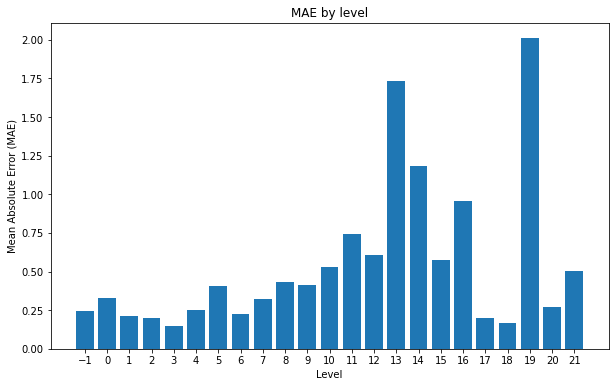

In [96]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [97]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.56
RMSE: 0.75

Round type: round
MSE: 0.58
RMSE: 0.76

Round type: 0.33
MSE: 0.58
RMSE: 0.76

Round type: 0.45
MSE: 0.57
RMSE: 0.76



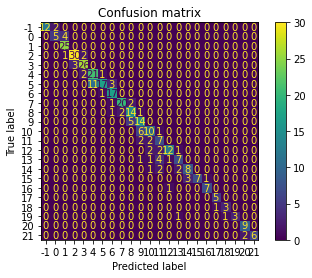

In [98]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [99]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 0.1379	valid_0's l1: 0.246737


In [100]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.25


In [102]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

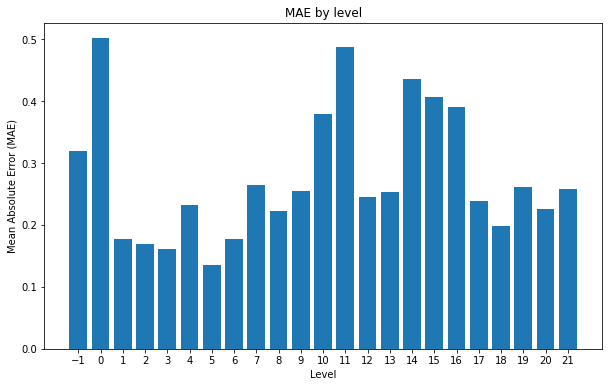

In [103]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [104]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



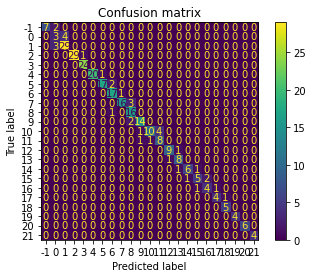

In [105]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [106]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 23:11:33,104] A new study created in memory with name: no-name-f8cf9265-393c-48fb-9488-24d43a2e8931

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



feature_fraction, val_score: 0.140037:  14%|######4                                      | 1/7 [00:06<00:38,  6.44s/it][I 2023-10-28 23:11:39,554] Trial 0 finished with value: 0.14003666614686308 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  14%|######4                                      | 1/7 [00:06<00:38,  6.44s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.152476 + 0.0430388
[200]	cv_agg's l2: 0.148726 + 0.041599
[300]	cv_agg's l2: 0.14708 + 0.039462
[400]	cv_agg's l2: 0.146136 + 0.0390308
[500]	cv_agg's l2: 0.145609 + 0.0387917
[600]	cv_agg's l2: 0.145313 + 0.0386915
[700]	cv_agg's l2: 0.145153 + 0.0386365



feature_fraction, val_score: 0.140037:  29%|############8                                | 2/7 [00:12<00:32,  6.44s/it][I 2023-10-28 23:11:45,995] Trial 1 finished with value: 0.1452171665393755 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  29%|############8                                | 2/7 [00:12<00:32,  6.44s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.17347 + 0.0426499
[200]	cv_agg's l2: 0.169084 + 0.0410434
[300]	cv_agg's l2: 0.167881 + 0.040061
[400]	cv_agg's l2: 0.167613 + 0.0399713
[500]	cv_agg's l2: 0.16752 + 0.0398721
[600]	cv_agg's l2: 0.167623 + 0.0397588


[700]	cv_agg's l2: 0.167549 + 0.0396271
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


feature_fraction, val_score: 0.140037:  43%|###################2                         | 3/7 [00:19<00:25,  6.31s/it][I 2023-10-28 23:11:52,139] Trial 2 finished with value: 0.16764216584675096 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  43%|###################2                         | 3/7 [00:19<00:25,  6.31s/it]

[100]	cv_agg's l2: 0.170664 + 0.0483907
[200]	cv_agg's l2: 0.166466 + 0.0450123
[300]	cv_agg's l2: 0.165102 + 0.0432595
[400]	cv_agg's l2: 0.164846 + 0.0428243
[500]	cv_agg's l2: 0.164535 + 0.0427393
[600]	cv_agg's l2: 0.164381 + 0.042648
[700]	cv_agg's l2: 0.164323 + 0.0425303



feature_fraction, val_score: 0.140037:  57%|#########################7                   | 4/7 [00:25<00:19,  6.42s/it][I 2023-10-28 23:11:58,734] Trial 3 finished with value: 0.1643903016246204 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  57%|#########################7                   | 4/7 [00:25<00:19,  6.42s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.170455 + 0.0433797
[200]	cv_agg's l2: 0.166276 + 0.0419211
[300]	cv_agg's l2: 0.165588 + 0.0402847
[400]	cv_agg's l2: 0.165313 + 0.0400834
[500]	cv_agg's l2: 0.164892 + 0.0397301
[600]	cv_agg's l2: 0.164835 + 0.0396282
[700]	cv_agg's l2: 0.164936 + 0.039613



feature_fraction, val_score: 0.140037:  71%|################################1            | 5/7 [00:32<00:12,  6.48s/it][I 2023-10-28 23:12:05,330] Trial 4 finished with value: 0.16483270059878058 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  71%|################################1            | 5/7 [00:32<00:12,  6.48s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.161864 + 0.0473163
[200]	cv_agg's l2: 0.156894 + 0.0456753
[300]	cv_agg's l2: 0.155301 + 0.0451226
[400]	cv_agg's l2: 0.154604 + 0.0448014
[500]	cv_agg's l2: 0.154112 + 0.0444894
[600]	cv_agg's l2: 0.153977 + 0.0442707
[700]	cv_agg's l2: 0.153892 + 0.0441906



feature_fraction, val_score: 0.140037:  86%|######################################5      | 6/7 [00:38<00:06,  6.41s/it][I 2023-10-28 23:12:11,607] Trial 5 finished with value: 0.15389558018690302 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.14003666614686308.

feature_fraction, val_score: 0.140037:  86%|######################################5      | 6/7 [00:38<00:06,  6.41s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.170224 + 0.0458705
[200]	cv_agg's l2: 0.165976 + 0.0435871
[300]	cv_agg's l2: 0.165344 + 0.042386
[400]	cv_agg's l2: 0.164518 + 0.0420384
[500]	cv_agg's l2: 0.164169 + 0.0417947
[600]	cv_agg's l2: 0.16415 + 0.0416715
[700]	cv_agg's l2: 0.1641 + 0.0415083



feature_fraction, val_score: 0.140037: 100%|#############################################| 7/7 [00:44<00:00,  6.39s/it]


Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



num_leaves, val_score: 0.140037:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:   5%|##5                                               | 1/20 [00:06<02:01,  6.38s/it][I 2023-10-28 23:12:24,234] Trial 7 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 157}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:   5%|##5                                               | 1/20 [00:06<02:01,  6.38s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



num_leaves, val_score: 0.140037:  10%|#####                                             | 2/20 [00:12<01:55,  6.42s/it][I 2023-10-28 23:12:30,680] Trial 8 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 236}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  10%|#####                                             | 2/20 [00:12<01:55,  6.42s/it]

[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091


[700]	cv_agg's l2: 0.140121 + 0.0359948
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


num_leaves, val_score: 0.140037:  15%|#######5                                          | 3/20 [00:19<01:51,  6.56s/it][I 2023-10-28 23:12:37,416] Trial 9 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 213}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  15%|#######5                                          | 3/20 [00:19<01:51,  6.56s/it]

[100]	cv_agg's l2: 0.152609 + 0.045701
[200]	cv_agg's l2: 0.148437 + 0.0438143
[300]	cv_agg's l2: 0.146876 + 0.0424098
[400]	cv_agg's l2: 0.145769 + 0.0415792
[500]	cv_agg's l2: 0.145334 + 0.0412732
[600]	cv_agg's l2: 0.145122 + 0.0409437
[700]	cv_agg's l2: 0.144967 + 0.0408165
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



num_leaves, val_score: 0.140037:  20%|##########                                        | 4/20 [00:25<01:42,  6.39s/it][I 2023-10-28 23:12:43,528] Trial 10 finished with value: 0.14508107209366417 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  20%|##########                                        | 4/20 [00:25<01:42,  6.39s/it]

[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  25%|############5                                     | 5/20 [00:31<01:34,  6.32s/it][I 2023-10-28 23:12:49,744] Trial 11 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 110}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  25%|############5                                     | 5/20 [00:31<01:34,  6.32s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  30%|###############                                   | 6/20 [00:38<01:29,  6.37s/it][I 2023-10-28 23:12:56,189] Trial 12 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 138}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  30%|###############                                   | 6/20 [00:38<01:29,  6.37s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  35%|#################5                                | 7/20 [00:45<01:24,  6.49s/it][I 2023-10-28 23:13:02,926] Trial 13 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 153}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  35%|#################5                                | 7/20 [00:45<01:24,  6.49s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  40%|####################                              | 8/20 [00:51<01:18,  6.51s/it][I 2023-10-28 23:13:09,473] Trial 14 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 64}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  40%|####################                              | 8/20 [00:51<01:18,  6.51s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091


[700]	cv_agg's l2: 0.140121 + 0.0359948
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


num_leaves, val_score: 0.140037:  45%|######################5                           | 9/20 [00:58<01:11,  6.48s/it][I 2023-10-28 23:13:15,902] Trial 15 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  45%|######################5                           | 9/20 [00:58<01:11,  6.48s/it]

[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  50%|########################5                        | 10/20 [01:04<01:03,  6.35s/it][I 2023-10-28 23:13:21,958] Trial 16 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 92}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  50%|########################5                        | 10/20 [01:04<01:03,  6.35s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  55%|##########################9                      | 11/20 [01:10<00:57,  6.39s/it][I 2023-10-28 23:13:28,431] Trial 17 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 200}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  55%|##########################9                      | 11/20 [01:10<00:57,  6.39s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



num_leaves, val_score: 0.140037:  60%|#############################4                   | 12/20 [01:17<00:51,  6.48s/it][I 2023-10-28 23:13:35,120] Trial 18 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 252}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  60%|#############################4                   | 12/20 [01:17<00:51,  6.48s/it]

[100]	cv_agg's l2: 0.153149 + 0.0438278
[200]	cv_agg's l2: 0.146377 + 0.0412592
[300]	cv_agg's l2: 0.143962 + 0.0406374
[400]	cv_agg's l2: 0.14362 + 0.0403505
[500]	cv_agg's l2: 0.143264 + 0.0392636
[600]	cv_agg's l2: 0.142885 + 0.0386764



num_leaves, val_score: 0.140037:  65%|###############################8                 | 13/20 [01:21<00:39,  5.67s/it][I 2023-10-28 23:13:38,917] Trial 19 finished with value: 0.1428457817880094 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  65%|###############################8                 | 13/20 [01:21<00:39,  5.67s/it]

[700]	cv_agg's l2: 0.142829 + 0.0382402
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  70%|##################################3              | 14/20 [01:30<00:41,  6.85s/it][I 2023-10-28 23:13:48,493] Trial 20 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  70%|##################################3              | 14/20 [01:30<00:41,  6.85s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  75%|####################################7            | 15/20 [01:39<00:37,  7.55s/it][I 2023-10-28 23:13:57,684] Trial 21 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  75%|####################################7            | 15/20 [01:39<00:37,  7.55s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  80%|#######################################2         | 16/20 [01:48<00:31,  7.89s/it][I 2023-10-28 23:14:06,351] Trial 22 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  80%|#######################################2         | 16/20 [01:48<00:31,  7.89s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  85%|#########################################6       | 17/20 [01:54<00:22,  7.39s/it][I 2023-10-28 23:14:12,567] Trial 23 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 174}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  85%|#########################################6       | 17/20 [01:54<00:22,  7.39s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  90%|############################################1    | 18/20 [02:00<00:13,  6.93s/it][I 2023-10-28 23:14:18,433] Trial 24 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  90%|############################################1    | 18/20 [02:00<00:13,  6.93s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037:  95%|##############################################5  | 19/20 [02:06<00:06,  6.61s/it][I 2023-10-28 23:14:24,297] Trial 25 finished with value: 0.14003666614686308 and parameters: {'num_leaves': 166}. Best is trial 7 with value: 0.14003666614686308.

num_leaves, val_score: 0.140037:  95%|##############################################5  | 19/20 [02:06<00:06,  6.61s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.1408 + 0.0369638
[500]	cv_agg's l2: 0.140282 + 0.0364882
[600]	cv_agg's l2: 0.140105 + 0.0362091
[700]	cv_agg's l2: 0.140121 + 0.0359948



num_leaves, val_score: 0.140037: 100%|#################################################| 20/20 [02:12<00:00,  6.65s/it]


Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



bagging, val_score: 0.140037:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.209273 + 0.0284577
[200]	cv_agg's l2: 0.195817 + 0.0219859
[300]	cv_agg's l2: 0.190669 + 0.0245647
[400]	cv_agg's l2: 0.186482 + 0.0208908
[500]	cv_agg's l2: 0.18672 + 0.0221691
[600]	cv_agg's l2: 0.188009 + 0.021553



bagging, val_score: 0.140037:  10%|#####3                                               | 1/10 [00:04<00:39,  4.44s/it][I 2023-10-28 23:14:35,310] Trial 27 finished with value: 0.18783648733346486 and parameters: {'bagging_fraction': 0.42706801141088224, 'bagging_freq': 2}. Best is trial 27 with value: 0.18783648733346486.

bagging, val_score: 0.140037:  10%|#####3                                               | 1/10 [00:04<00:39,  4.44s/it]

[700]	cv_agg's l2: 0.187669 + 0.0198194
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150554 + 0.0402772
[200]	cv_agg's l2: 0.145958 + 0.0387166
[300]	cv_agg's l2: 0.143773 + 0.0371132
[400]	cv_agg's l2: 0.143236 + 0.0364959
[500]	cv_agg's l2: 0.142902 + 0.0360978
[600]	cv_agg's l2: 0.142586 + 0.0356432
[700]	cv_agg's l2: 0.142374 + 0.0352946



bagging, val_score: 0.140037:  20%|##########6                                          | 2/10 [00:10<00:44,  5.53s/it][I 2023-10-28 23:14:41,607] Trial 28 finished with value: 0.1424840796058414 and parameters: {'bagging_fraction': 0.9894152791790459, 'bagging_freq': 7}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  20%|##########6                                          | 2/10 [00:10<00:44,  5.53s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.166147 + 0.0389871
[200]	cv_agg's l2: 0.156152 + 0.0345166
[300]	cv_agg's l2: 0.153685 + 0.0333522
[400]	cv_agg's l2: 0.152182 + 0.0334552
[500]	cv_agg's l2: 0.152079 + 0.0334557
[600]	cv_agg's l2: 0.152092 + 0.0341632



bagging, val_score: 0.140037:  30%|###############9                                     | 3/10 [00:15<00:36,  5.23s/it][I 2023-10-28 23:14:46,475] Trial 29 finished with value: 0.152132516719549 and parameters: {'bagging_fraction': 0.7228395279236075, 'bagging_freq': 6}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  30%|###############9                                     | 3/10 [00:15<00:36,  5.23s/it]

[700]	cv_agg's l2: 0.151971 + 0.0342191
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.196231 + 0.0376867
[200]	cv_agg's l2: 0.183082 + 0.0362473
[300]	cv_agg's l2: 0.181079 + 0.0319083
[400]	cv_agg's l2: 0.179095 + 0.0307101
[500]	cv_agg's l2: 0.175151 + 0.0292095
[600]	cv_agg's l2: 0.176271 + 0.0296442



bagging, val_score: 0.140037:  40%|#####################2                               | 4/10 [00:18<00:26,  4.47s/it][I 2023-10-28 23:14:49,775] Trial 30 finished with value: 0.17648232063822838 and parameters: {'bagging_fraction': 0.41827674348498384, 'bagging_freq': 1}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  40%|#####################2                               | 4/10 [00:18<00:26,  4.47s/it]

[700]	cv_agg's l2: 0.176579 + 0.0283139
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.152837 + 0.0501045
[200]	cv_agg's l2: 0.149106 + 0.0478446
[300]	cv_agg's l2: 0.14812 + 0.0468063
[400]	cv_agg's l2: 0.147485 + 0.0460078
[500]	cv_agg's l2: 0.146968 + 0.0455396
[600]	cv_agg's l2: 0.146517 + 0.0454554


[700]	cv_agg's l2: 0.146418 + 0.0451274
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


bagging, val_score: 0.140037:  50%|##########################5                          | 5/10 [00:24<00:24,  4.86s/it][I 2023-10-28 23:14:55,328] Trial 31 finished with value: 0.14651131938192244 and parameters: {'bagging_fraction': 0.9854505871674177, 'bagging_freq': 4}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  50%|##########################5                          | 5/10 [00:24<00:24,  4.86s/it]

[100]	cv_agg's l2: 0.17025 + 0.0334295
[200]	cv_agg's l2: 0.164676 + 0.0317271
[300]	cv_agg's l2: 0.160935 + 0.0308798
[400]	cv_agg's l2: 0.159872 + 0.0305162
[500]	cv_agg's l2: 0.159927 + 0.0311026
[600]	cv_agg's l2: 0.159334 + 0.0313957



bagging, val_score: 0.140037:  60%|###############################8                     | 6/10 [00:28<00:17,  4.48s/it][I 2023-10-28 23:14:59,076] Trial 32 finished with value: 0.15970092051610787 and parameters: {'bagging_fraction': 0.6514672813472759, 'bagging_freq': 4}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  60%|###############################8                     | 6/10 [00:28<00:17,  4.48s/it]

[700]	cv_agg's l2: 0.159244 + 0.0314277
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.157228 + 0.0420805
[200]	cv_agg's l2: 0.149604 + 0.0394302
[300]	cv_agg's l2: 0.146683 + 0.038971
[400]	cv_agg's l2: 0.145732 + 0.0382115
[500]	cv_agg's l2: 0.145841 + 0.0383237
[600]	cv_agg's l2: 0.145714 + 0.0380183


[700]	cv_agg's l2: 0.145195 + 0.0378797
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


bagging, val_score: 0.140037:  70%|#####################################                | 7/10 [00:32<00:13,  4.54s/it][I 2023-10-28 23:15:03,734] Trial 33 finished with value: 0.14558928572118257 and parameters: {'bagging_fraction': 0.7899626973456316, 'bagging_freq': 3}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  70%|#####################################                | 7/10 [00:32<00:13,  4.54s/it]

[100]	cv_agg's l2: 0.185932 + 0.0348137
[200]	cv_agg's l2: 0.171271 + 0.0343064
[300]	cv_agg's l2: 0.168185 + 0.0324172
[400]	cv_agg's l2: 0.167364 + 0.0304579
[500]	cv_agg's l2: 0.165741 + 0.0298699
[600]	cv_agg's l2: 0.164663 + 0.028683



bagging, val_score: 0.140037:  80%|##########################################4          | 8/10 [00:36<00:08,  4.22s/it][I 2023-10-28 23:15:07,268] Trial 34 finished with value: 0.16453372941399463 and parameters: {'bagging_fraction': 0.5977250900954071, 'bagging_freq': 6}. Best is trial 28 with value: 0.1424840796058414.

bagging, val_score: 0.140037:  80%|##########################################4          | 8/10 [00:36<00:08,  4.22s/it]

[700]	cv_agg's l2: 0.1645 + 0.0276623
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149811 + 0.0295487
[200]	cv_agg's l2: 0.144045 + 0.0267843
[300]	cv_agg's l2: 0.141841 + 0.0267271
[400]	cv_agg's l2: 0.140843 + 0.026328
[500]	cv_agg's l2: 0.140787 + 0.025906
[600]	cv_agg's l2: 0.140544 + 0.0256669



bagging, val_score: 0.140037:  90%|###############################################7     | 9/10 [00:41<00:04,  4.42s/it][I 2023-10-28 23:15:12,121] Trial 35 finished with value: 0.14052202082135484 and parameters: {'bagging_fraction': 0.8507818855245155, 'bagging_freq': 1}. Best is trial 35 with value: 0.14052202082135484.



[700]	cv_agg's l2: 0.140407 + 0.0253832
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


bagging, val_score: 0.140037:  90%|###############################################7     | 9/10 [00:41<00:04,  4.42s/it]

[100]	cv_agg's l2: 0.187718 + 0.0340309
[200]	cv_agg's l2: 0.177134 + 0.0302877
[300]	cv_agg's l2: 0.17326 + 0.0311332
[400]	cv_agg's l2: 0.168437 + 0.0310277
[500]	cv_agg's l2: 0.167812 + 0.0334408
[600]	cv_agg's l2: 0.167502 + 0.0331572



bagging, val_score: 0.140037: 100%|####################################################| 10/10 [00:44<00:00,  4.48s/it]


[700]	cv_agg's l2: 0.166732 + 0.0334762
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



feature_fraction_stage2, val_score: 0.140037:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150588 + 0.0445368
[200]	cv_agg's l2: 0.146829 + 0.0420839
[300]	cv_agg's l2: 0.145983 + 0.0402492
[400]	cv_agg's l2: 0.145259 + 0.039709
[500]	cv_agg's l2: 0.144924 + 0.0392144
[600]	cv_agg's l2: 0.144787 + 0.0389536


[700]	cv_agg's l2: 0.14473 + 0.0387474
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


feature_fraction_stage2, val_score: 0.140037:  33%|############6                         | 1/3 [00:06<00:12,  6.37s/it][I 2023-10-28 23:15:22,069] Trial 37 finished with value: 0.1447703347293501 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 0.1447703347293501.

feature_fraction_stage2, val_score: 0.140037:  33%|############6                         | 1/3 [00:06<00:12,  6.37s/it]

[100]	cv_agg's l2: 0.156332 + 0.0474761
[200]	cv_agg's l2: 0.152991 + 0.0449213
[300]	cv_agg's l2: 0.151804 + 0.0431017
[400]	cv_agg's l2: 0.150972 + 0.0422396
[500]	cv_agg's l2: 0.150338 + 0.0419983
[600]	cv_agg's l2: 0.150132 + 0.0418332



feature_fraction_stage2, val_score: 0.140037:  67%|#########################3            | 2/3 [00:11<00:05,  5.52s/it][I 2023-10-28 23:15:26,994] Trial 38 finished with value: 0.15011355865041284 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.1447703347293501.

feature_fraction_stage2, val_score: 0.140037:  67%|#########################3            | 2/3 [00:11<00:05,  5.52s/it]

[700]	cv_agg's l2: 0.150045 + 0.041791
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.155317 + 0.0432815
[200]	cv_agg's l2: 0.152716 + 0.0412952
[300]	cv_agg's l2: 0.151085 + 0.039649
[400]	cv_agg's l2: 0.150482 + 0.0388243
[500]	cv_agg's l2: 0.150025 + 0.0384776
[600]	cv_agg's l2: 0.149719 + 0.0381999


[700]	cv_agg's l2: 0.149601 + 0.0380213
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


feature_fraction_stage2, val_score: 0.140037: 100%|######################################| 3/3 [00:16<00:00,  5.51s/it]

regularization_factors, val_score: 0.140037:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.149902 + 0.0433967
[200]	cv_agg's l2: 0.145609 + 0.0419604
[300]	cv_agg's l2: 0.14504 + 0.0423645
[400]	cv_agg's l2: 0.145038 + 0.0423642
[500]	cv_agg's l2: 0.145038 + 0.0423643
[600]	cv_agg's l2: 0.145038 + 0.0423643



regularization_factors, val_score: 0.140037:   5%|#9                                    | 1/20 [00:02<00:42,  2.24s/it][I 2023-10-28 23:15:34,492] Trial 40 finished with value: 0.14503811615120005 and parameters: {'lambda_l1': 1.0424101941703148, 'lambda_l2': 0.010882247375379645}. Best is trial 40 with value: 0.14503811615120005.

regularization_factors, val_score: 0.140037:   5%|#9                                    | 1/20 [00:02<00:42,  2.24s/it]

[700]	cv_agg's l2: 0.145038 + 0.0423643
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.14831 + 0.0430425
[200]	cv_agg's l2: 0.143601 + 0.0396548
[300]	cv_agg's l2: 0.141791 + 0.0381375
[400]	cv_agg's l2: 0.140804 + 0.0369605
[500]	cv_agg's l2: 0.140333 + 0.0364479
[600]	cv_agg's l2: 0.140147 + 0.036175



regularization_factors, val_score: 0.140037:  10%|###8                                  | 2/20 [00:07<01:14,  4.13s/it][I 2023-10-28 23:15:39,936] Trial 41 finished with value: 0.14010542077490093 and parameters: {'lambda_l1': 9.904137144950223e-08, 'lambda_l2': 1.4040800115096057e-08}. Best is trial 41 with value: 0.14010542077490093.


[700]	cv_agg's l2: 0.140174 + 0.0359551
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



regularization_factors, val_score: 0.140037:  10%|###8                                  | 2/20 [00:07<01:14,  4.13s/it]

[100]	cv_agg's l2: 0.157719 + 0.0378396
[200]	cv_agg's l2: 0.150472 + 0.0355403
[300]	cv_agg's l2: 0.147817 + 0.034897
[400]	cv_agg's l2: 0.146104 + 0.0335251
[500]	cv_agg's l2: 0.145484 + 0.0330638
[600]	cv_agg's l2: 0.145119 + 0.032974
[700]	cv_agg's l2: 0.145094 + 0.0329916



regularization_factors, val_score: 0.140037:  15%|#####7                                | 3/20 [00:15<01:41,  6.00s/it][I 2023-10-28 23:15:48,156] Trial 42 finished with value: 0.14510270239352144 and parameters: {'lambda_l1': 1.4163618208826154e-08, 'lambda_l2': 6.7800171421222535}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  15%|#####7                                | 3/20 [00:15<01:41,  6.00s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.182127 + 0.0529383
[200]	cv_agg's l2: 0.17868 + 0.0520375
[300]	cv_agg's l2: 0.178678 + 0.0520387
[400]	cv_agg's l2: 0.178678 + 0.0520387
[500]	cv_agg's l2: 0.178678 + 0.0520387
[600]	cv_agg's l2: 0.178678 + 0.0520387



regularization_factors, val_score: 0.140037:  20%|#######6                              | 4/20 [00:18<01:16,  4.75s/it][I 2023-10-28 23:15:51,010] Trial 43 finished with value: 0.17867751332970347 and parameters: {'lambda_l1': 5.952080959952164, 'lambda_l2': 5.601463055378031e-08}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  20%|#######6                              | 4/20 [00:18<01:16,  4.75s/it]

[700]	cv_agg's l2: 0.178678 + 0.0520387
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150454 + 0.0423108
[200]	cv_agg's l2: 0.146767 + 0.040387
[300]	cv_agg's l2: 0.145135 + 0.0385625
[400]	cv_agg's l2: 0.144122 + 0.0376661
[500]	cv_agg's l2: 0.14365 + 0.0371738
[600]	cv_agg's l2: 0.143477 + 0.0369663
[700]	cv_agg's l2: 0.143406 + 0.0368073



regularization_factors, val_score: 0.140037:  25%|#########5                            | 5/20 [00:25<01:23,  5.59s/it][I 2023-10-28 23:15:58,081] Trial 44 finished with value: 0.14336952080633422 and parameters: {'lambda_l1': 0.00031138563751118855, 'lambda_l2': 2.380042504735013e-05}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  25%|#########5                            | 5/20 [00:25<01:23,  5.59s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150743 + 0.0420927
[200]	cv_agg's l2: 0.146824 + 0.0406718
[300]	cv_agg's l2: 0.145537 + 0.0394996
[400]	cv_agg's l2: 0.1446 + 0.0384604
[500]	cv_agg's l2: 0.144544 + 0.0380324
[600]	cv_agg's l2: 0.144237 + 0.0377785
[700]	cv_agg's l2: 0.144076 + 0.0375654



regularization_factors, val_score: 0.140037:  30%|###########4                          | 6/20 [00:33<01:25,  6.13s/it][I 2023-10-28 23:16:05,248] Trial 45 finished with value: 0.14419424080535023 and parameters: {'lambda_l1': 0.0003209777539757708, 'lambda_l2': 0.00015368209428990223}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  30%|###########4                          | 6/20 [00:33<01:25,  6.13s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.158386 + 0.037363
[200]	cv_agg's l2: 0.150137 + 0.0356241
[300]	cv_agg's l2: 0.147563 + 0.0341822
[400]	cv_agg's l2: 0.146269 + 0.0333898
[500]	cv_agg's l2: 0.145237 + 0.0324643
[600]	cv_agg's l2: 0.144699 + 0.0319055
[700]	cv_agg's l2: 0.144441 + 0.0315926



regularization_factors, val_score: 0.140037:  35%|#############3                        | 7/20 [00:39<01:22,  6.33s/it][I 2023-10-28 23:16:12,005] Trial 46 finished with value: 0.14464568946055736 and parameters: {'lambda_l1': 5.33213409862291e-06, 'lambda_l2': 5.630821154921414}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  35%|#############3                        | 7/20 [00:39<01:22,  6.33s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150746 + 0.0444244
[200]	cv_agg's l2: 0.146934 + 0.0416382
[300]	cv_agg's l2: 0.145821 + 0.0403121
[400]	cv_agg's l2: 0.144842 + 0.0394264
[500]	cv_agg's l2: 0.144711 + 0.0390988
[600]	cv_agg's l2: 0.144484 + 0.038915


[700]	cv_agg's l2: 0.144389 + 0.0387894
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


regularization_factors, val_score: 0.140037:  40%|###############2                      | 8/20 [00:46<01:16,  6.40s/it][I 2023-10-28 23:16:18,550] Trial 47 finished with value: 0.1444623789875666 and parameters: {'lambda_l1': 0.10822939174744133, 'lambda_l2': 1.3619098072305968e-06}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  40%|###############2                      | 8/20 [00:46<01:16,  6.40s/it]

[100]	cv_agg's l2: 0.150886 + 0.045154
[200]	cv_agg's l2: 0.145889 + 0.0427477
[300]	cv_agg's l2: 0.144422 + 0.04078
[400]	cv_agg's l2: 0.143274 + 0.0400076
[500]	cv_agg's l2: 0.143119 + 0.0394838
[600]	cv_agg's l2: 0.14302 + 0.0392426
[700]	cv_agg's l2: 0.143008 + 0.0390465



regularization_factors, val_score: 0.140037:  45%|#################1                    | 9/20 [00:53<01:13,  6.70s/it][I 2023-10-28 23:16:25,905] Trial 48 finished with value: 0.1430450593266099 and parameters: {'lambda_l1': 0.029280189977138847, 'lambda_l2': 0.030915069171881818}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  45%|#################1                    | 9/20 [00:53<01:13,  6.70s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149388 + 0.0433463
[200]	cv_agg's l2: 0.145263 + 0.0403215
[300]	cv_agg's l2: 0.143915 + 0.0386463
[400]	cv_agg's l2: 0.143157 + 0.0376208
[500]	cv_agg's l2: 0.142651 + 0.0371848
[600]	cv_agg's l2: 0.1425 + 0.0368734
[700]	cv_agg's l2: 0.14233 + 0.0367535



regularization_factors, val_score: 0.140037:  50%|##################5                  | 10/20 [01:00<01:08,  6.89s/it][I 2023-10-28 23:16:33,217] Trial 49 finished with value: 0.14237796506956338 and parameters: {'lambda_l1': 1.296087947654e-06, 'lambda_l2': 2.0175478222871075e-06}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  50%|##################5                  | 10/20 [01:00<01:08,  6.89s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.147895 + 0.040987
[200]	cv_agg's l2: 0.143867 + 0.038874
[300]	cv_agg's l2: 0.142771 + 0.0377572
[400]	cv_agg's l2: 0.141596 + 0.0363128
[500]	cv_agg's l2: 0.141257 + 0.0360999
[600]	cv_agg's l2: 0.141097 + 0.0360762
[700]	cv_agg's l2: 0.140918 + 0.0357414



regularization_factors, val_score: 0.140037:  55%|####################3                | 11/20 [01:07<01:02,  6.89s/it][I 2023-10-28 23:16:40,110] Trial 50 finished with value: 0.14105239417225007 and parameters: {'lambda_l1': 0.0033341777753903637, 'lambda_l2': 0.0013591612691589423}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  55%|####################3                | 11/20 [01:07<01:02,  6.89s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.151018 + 0.0432718
[200]	cv_agg's l2: 0.147502 + 0.0409492
[300]	cv_agg's l2: 0.146073 + 0.0389822
[400]	cv_agg's l2: 0.145422 + 0.0378823
[500]	cv_agg's l2: 0.145145 + 0.0375012
[600]	cv_agg's l2: 0.144803 + 0.0372254
[700]	cv_agg's l2: 0.144766 + 0.0371055



regularization_factors, val_score: 0.140037:  60%|######################2              | 12/20 [01:15<00:56,  7.04s/it][I 2023-10-28 23:16:47,479] Trial 51 finished with value: 0.14483508075779328 and parameters: {'lambda_l1': 1.4492973543559294e-05, 'lambda_l2': 0.23223976247235273}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  60%|######################2              | 12/20 [01:15<00:56,  7.04s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.183644 + 0.0509436
[200]	cv_agg's l2: 0.180118 + 0.0504271
[300]	cv_agg's l2: 0.180116 + 0.0504283
[400]	cv_agg's l2: 0.180116 + 0.0504283
[500]	cv_agg's l2: 0.180116 + 0.0504283
[600]	cv_agg's l2: 0.180116 + 0.0504283



regularization_factors, val_score: 0.140037:  65%|########################             | 13/20 [01:17<00:38,  5.51s/it][I 2023-10-28 23:16:49,470] Trial 52 finished with value: 0.180115658374977 and parameters: {'lambda_l1': 6.093754668481234, 'lambda_l2': 0.0009007748824193255}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  65%|########################             | 13/20 [01:17<00:38,  5.51s/it]

[700]	cv_agg's l2: 0.180116 + 0.0504283
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149527 + 0.0436281
[200]	cv_agg's l2: 0.146218 + 0.0419869
[300]	cv_agg's l2: 0.144695 + 0.0408981
[400]	cv_agg's l2: 0.143964 + 0.039962
[500]	cv_agg's l2: 0.14352 + 0.0394997
[600]	cv_agg's l2: 0.143404 + 0.0393885
[700]	cv_agg's l2: 0.143332 + 0.039122



regularization_factors, val_score: 0.140037:  70%|#########################9           | 14/20 [01:24<00:36,  6.01s/it][I 2023-10-28 23:16:56,628] Trial 53 finished with value: 0.14337438258389537 and parameters: {'lambda_l1': 1.1564613882103473e-08, 'lambda_l2': 3.8481521420818814e-05}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  70%|#########################9           | 14/20 [01:24<00:36,  6.01s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150287 + 0.0396665
[200]	cv_agg's l2: 0.144691 + 0.037988
[300]	cv_agg's l2: 0.143297 + 0.0365145
[400]	cv_agg's l2: 0.142998 + 0.0359036
[500]	cv_agg's l2: 0.142641 + 0.0353878
[600]	cv_agg's l2: 0.142469 + 0.0352394



regularization_factors, val_score: 0.140037:  75%|###########################7         | 15/20 [01:30<00:29,  5.94s/it][I 2023-10-28 23:17:02,405] Trial 54 finished with value: 0.14241679337336824 and parameters: {'lambda_l1': 0.17044010127696171, 'lambda_l2': 0.6213363550039316}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  75%|###########################7         | 15/20 [01:30<00:29,  5.94s/it]

[700]	cv_agg's l2: 0.142396 + 0.0352109
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150048 + 0.0409921
[200]	cv_agg's l2: 0.145909 + 0.0387387
[300]	cv_agg's l2: 0.145125 + 0.0377301
[400]	cv_agg's l2: 0.144453 + 0.0369289
[500]	cv_agg's l2: 0.144104 + 0.0363935
[600]	cv_agg's l2: 0.143851 + 0.0359531
[700]	cv_agg's l2: 0.143857 + 0.035862



regularization_factors, val_score: 0.140037:  80%|#############################6       | 16/20 [01:37<00:25,  6.32s/it][I 2023-10-28 23:17:09,606] Trial 55 finished with value: 0.1438541610526418 and parameters: {'lambda_l1': 0.00010857067584043463, 'lambda_l2': 0.010404263902467105}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  80%|#############################6       | 16/20 [01:37<00:25,  6.32s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.150134 + 0.0450826
[200]	cv_agg's l2: 0.145841 + 0.0430607
[300]	cv_agg's l2: 0.144179 + 0.0411172
[400]	cv_agg's l2: 0.14346 + 0.0399574
[500]	cv_agg's l2: 0.143086 + 0.0393101
[600]	cv_agg's l2: 0.142857 + 0.0391493
[700]	cv_agg's l2: 0.142684 + 0.0388446



regularization_factors, val_score: 0.140037:  85%|###############################4     | 17/20 [01:44<00:19,  6.63s/it][I 2023-10-28 23:17:16,952] Trial 56 finished with value: 0.1428404457048153 and parameters: {'lambda_l1': 0.005322047625324592, 'lambda_l2': 4.2033084084345464e-07}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  85%|###############################4     | 17/20 [01:44<00:19,  6.63s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149377 + 0.0433549
[200]	cv_agg's l2: 0.145274 + 0.0403131
[300]	cv_agg's l2: 0.143567 + 0.0389275
[400]	cv_agg's l2: 0.142781 + 0.0379277
[500]	cv_agg's l2: 0.142322 + 0.0374534
[600]	cv_agg's l2: 0.142131 + 0.0371902
[700]	cv_agg's l2: 0.142106 + 0.0369795



regularization_factors, val_score: 0.140037:  90%|#################################3   | 18/20 [01:51<00:13,  6.82s/it][I 2023-10-28 23:17:24,220] Trial 57 finished with value: 0.14208382353711743 and parameters: {'lambda_l1': 5.643012909690612e-07, 'lambda_l2': 1.4526864040971542e-05}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  90%|#################################3   | 18/20 [01:51<00:13,  6.82s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149628 + 0.0418539
[200]	cv_agg's l2: 0.146062 + 0.0406764
[300]	cv_agg's l2: 0.145203 + 0.0393072
[400]	cv_agg's l2: 0.144786 + 0.0383557
[500]	cv_agg's l2: 0.144175 + 0.0377396
[600]	cv_agg's l2: 0.143911 + 0.0374655
[700]	cv_agg's l2: 0.143852 + 0.0372748



regularization_factors, val_score: 0.140037:  95%|###################################1 | 19/20 [02:00<00:07,  7.19s/it][I 2023-10-28 23:17:32,259] Trial 58 finished with value: 0.1438950800692093 and parameters: {'lambda_l1': 2.408200565083684e-05, 'lambda_l2': 0.0002883959000824929}. Best is trial 41 with value: 0.14010542077490093.

regularization_factors, val_score: 0.140037:  95%|###################################1 | 19/20 [02:00<00:07,  7.19s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.151883 + 0.0428627
[200]	cv_agg's l2: 0.148052 + 0.041131
[300]	cv_agg's l2: 0.146273 + 0.0391521
[400]	cv_agg's l2: 0.145613 + 0.038626
[500]	cv_agg's l2: 0.145097 + 0.0381569
[600]	cv_agg's l2: 0.144946 + 0.0378414
[700]	cv_agg's l2: 0.144825 + 0.0374967



regularization_factors, val_score: 0.140037: 100%|#####################################| 20/20 [02:07<00:00,  6.38s/it]


Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575



min_data_in_leaf, val_score: 0.140037:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150568 + 0.0404626
[200]	cv_agg's l2: 0.147763 + 0.039528
[300]	cv_agg's l2: 0.14687 + 0.0388849
[400]	cv_agg's l2: 0.1467 + 0.0385373
[500]	cv_agg's l2: 0.146506 + 0.0383514
[600]	cv_agg's l2: 0.146441 + 0.038284
[700]	cv_agg's l2: 0.146403 + 0.0382309



min_data_in_leaf, val_score: 0.140037:  20%|#########                                    | 1/5 [00:07<00:31,  7.83s/it][I 2023-10-28 23:17:47,760] Trial 60 finished with value: 0.14641793788138396 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.14641793788138396.

min_data_in_leaf, val_score: 0.140037:  20%|#########                                    | 1/5 [00:07<00:31,  7.83s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.226101 + 0.0444854
[200]	cv_agg's l2: 0.215154 + 0.0406061
[300]	cv_agg's l2: 0.211924 + 0.0396815
[400]	cv_agg's l2: 0.209992 + 0.0395879
[500]	cv_agg's l2: 0.21016 + 0.0376401
[600]	cv_agg's l2: 0.210919 + 0.0366558



min_data_in_leaf, val_score: 0.140037:  40%|##################                           | 2/5 [00:11<00:16,  5.41s/it][I 2023-10-28 23:17:51,469] Trial 61 finished with value: 0.21120936441305455 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.14641793788138396.

min_data_in_leaf, val_score: 0.140037:  40%|##################                           | 2/5 [00:11<00:16,  5.41s/it]

[700]	cv_agg's l2: 0.212202 + 0.035898
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.705201 + 0.0482121
[200]	cv_agg's l2: 0.668369 + 0.0432516
[300]	cv_agg's l2: 0.648591 + 0.0482051
[400]	cv_agg's l2: 0.631143 + 0.0516299
[500]	cv_agg's l2: 0.622637 + 0.0541064
[600]	cv_agg's l2: 0.616875 + 0.0551415



min_data_in_leaf, val_score: 0.140037:  60%|###########################                  | 3/5 [00:14<00:08,  4.23s/it][I 2023-10-28 23:17:54,310] Trial 62 finished with value: 0.6160584406128959 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.14641793788138396.

min_data_in_leaf, val_score: 0.140037:  60%|###########################                  | 3/5 [00:14<00:08,  4.23s/it]

[700]	cv_agg's l2: 0.61365 + 0.0561514
Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.149432 + 0.0424684
[200]	cv_agg's l2: 0.148849 + 0.041119
[300]	cv_agg's l2: 0.148629 + 0.0406268
[400]	cv_agg's l2: 0.148491 + 0.0404993
[500]	cv_agg's l2: 0.148421 + 0.040381
[600]	cv_agg's l2: 0.148398 + 0.0403221
[700]	cv_agg's l2: 0.148377 + 0.0403093



min_data_in_leaf, val_score: 0.140037:  80%|####################################         | 4/5 [00:23<00:06,  6.18s/it][I 2023-10-28 23:18:03,477] Trial 63 finished with value: 0.14838546020230886 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.14641793788138396.

min_data_in_leaf, val_score: 0.140037:  80%|####################################         | 4/5 [00:23<00:06,  6.18s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575
[100]	cv_agg's l2: 0.151894 + 0.0390295
[200]	cv_agg's l2: 0.146955 + 0.0365106
[300]	cv_agg's l2: 0.144953 + 0.0356578
[400]	cv_agg's l2: 0.14415 + 0.034548
[500]	cv_agg's l2: 0.144152 + 0.0345476
[600]	cv_agg's l2: 0.144004 + 0.0341303
[700]	cv_agg's l2: 0.14404 + 0.0340053



min_data_in_leaf, val_score: 0.140037: 100%|#############################################| 5/5 [00:30<00:00,  6.05s/it]

Early stopping, best iteration is:
[626]	cv_agg's l2: 0.140037 + 0.0360575


In [107]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14003666614686308
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [108]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [109]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.33
MSE test: 0.11
MAE test: 0.23



In [110]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

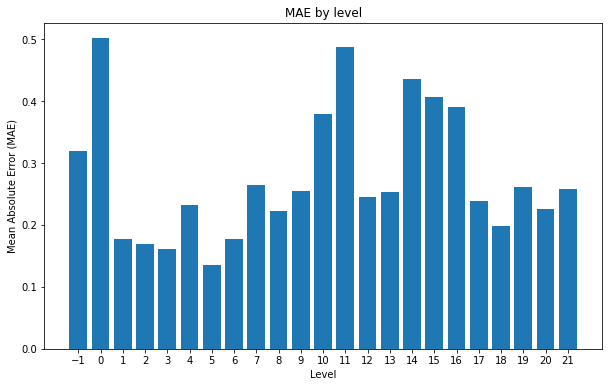

In [111]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [112]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.04
RMSE: 0.21

Round type: round
MSE: 0.04
RMSE: 0.19

Round type: 0.33
MSE: 0.04
RMSE: 0.20

Round type: 0.45
MSE: 0.04
RMSE: 0.20



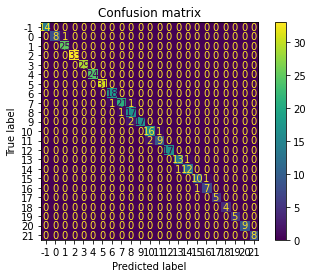

In [113]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [114]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,50,0.913533,0.955789,0.459619
1,chronological,Optuna,50,0.560775,0.748849,0.409903
2,random,normal,50,0.137900,0.371349,0.246737
3,random,Optuna,50,0.110747,0.332787,0.226069


In [115]:
from training.results import plot_summary

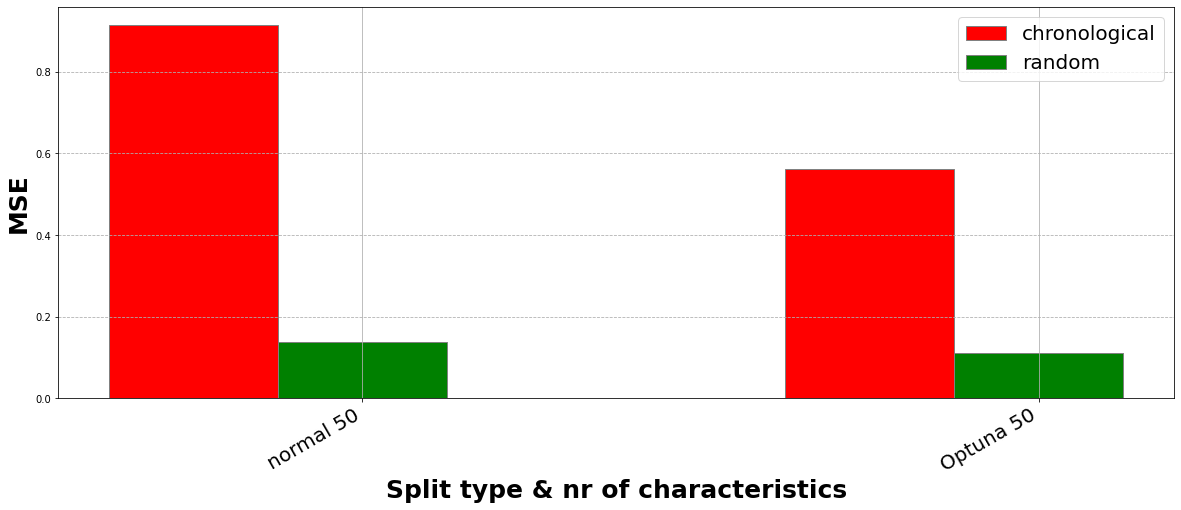

In [116]:
plot_summary(results, "MSE")

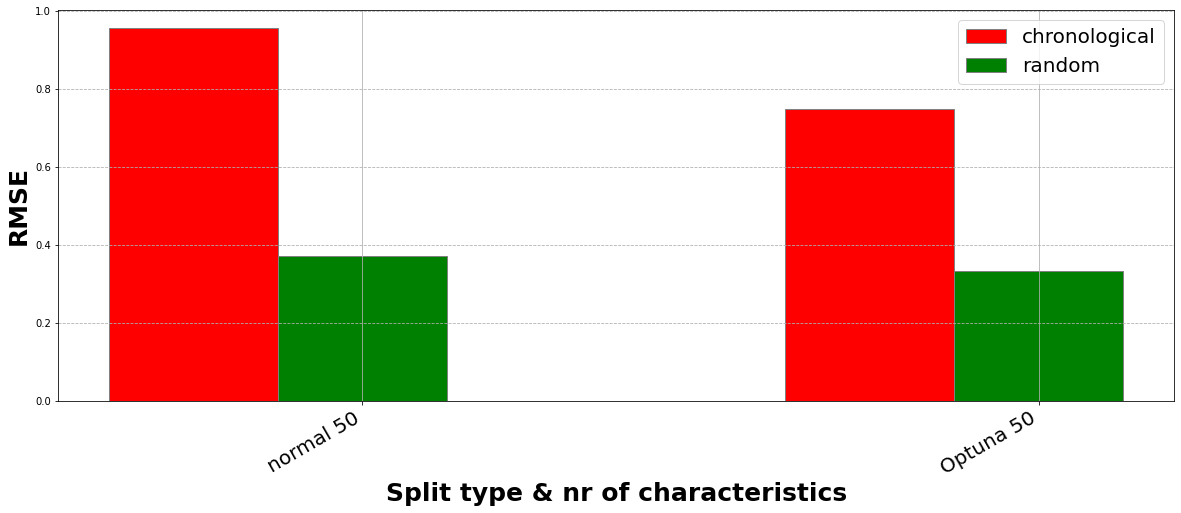

In [117]:
plot_summary(results, "RMSE")

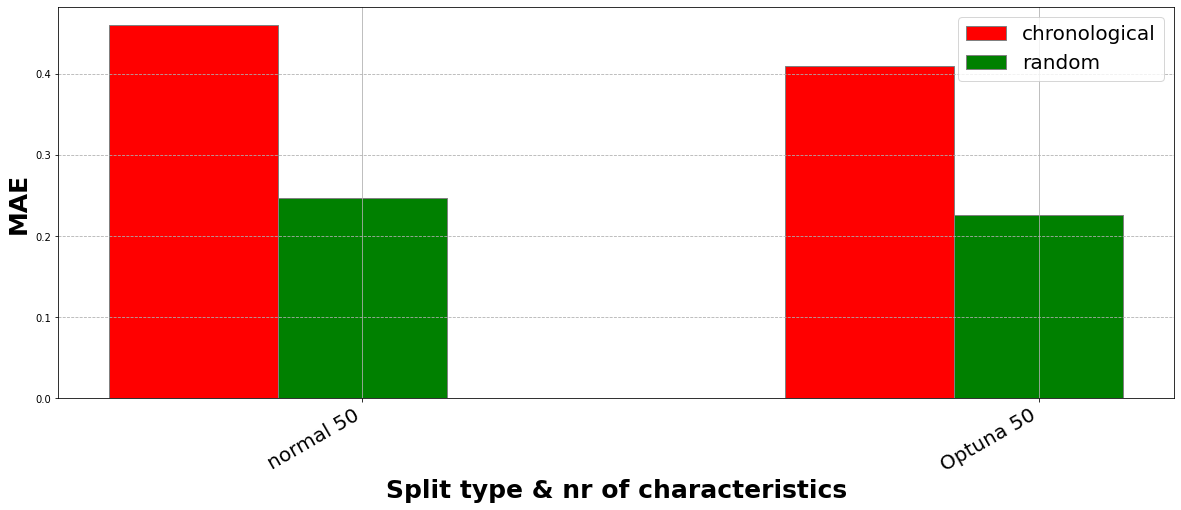

In [118]:
plot_summary(results, "MAE")

In [119]:
results.to_json("./lightgbm_final_results.json")